# 라이브러리

In [3]:
!pip install catboost
!pip install category_encoders

^C


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, random
warnings.filterwarnings('ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

## 데이터 로드

In [73]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [74]:
train.shape, test.shape

((26457, 20), (10000, 19))

## 데이터 전처리

### 1. 결측치 처리

In [75]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [76]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

In [77]:
train.fillna('NaN', inplace = True)
test.fillna('NaN', inplace = True)

In [78]:
train['occyp_type'].value_counts()

NaN                      8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

### 2. 이상치처리

* EDA에서 확인한 family_size가 7 초과인 데이터 제거

In [79]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [80]:
train['family_size'].value_counts()

2.0    14106
1.0     5109
3.0     4632
4.0     2260
5.0      291
6.0       44
7.0        9
Name: family_size, dtype: int64

In [81]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


## Feature Enginearing

### 1. 의미없는 변수 제거

In [82]:
# index, Flag_mobil(모든 값이 1)
train.drop(['index','FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index','FLAG_MOBIL'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED

In [83]:
train['DAYS_EMPLOYED'].value_counts()

 365243    4438
-401         57
-1539        47
-200         45
-2087        44
           ... 
-4874         1
-4858         1
-3495         1
-740          1
-12278        1
Name: DAYS_EMPLOYED, Length: 3469, dtype: int64

In [84]:
# 0이상인 것은 모두 365243인 것 확인
train[train['DAYS_EMPLOYED'] >= 0]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,0,1,0,NaN,1.0,-41.0,2.0
18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,0,0,0,NaN,2.0,-37.0,2.0
21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,0,1,0,NaN,2.0,-7.0,2.0
24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,0,1,0,NaN,1.0,-5.0,2.0
46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,0,1,0,NaN,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26425,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,0,0,1,NaN,1.0,-60.0,1.0
26426,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,0,1,0,NaN,2.0,-17.0,1.0
26433,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,0,0,0,NaN,2.0,-57.0,2.0
26435,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,0,0,0,NaN,1.0,-43.0,2.0


In [85]:
# 양수 데이터느 현재 무직으로 판단, 0처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x> 0 else x) 

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED 양수로 변환

In [86]:
cols = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']

for col in cols:
    train[col] = np.abs(train[col])
    test[col] = np.abs(test[col])

In [87]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0


## 4. 파생변수
* numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
* category 변수는 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음

In [88]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)
    

In [89]:
df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,...,1.0,60,1.0,1.0,0,0.0,0.0,5.115962,56250.0,0_112500.0_21990_0_0_1_0_2.0_M_Y_N_Pensioner_S...
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,18964,...,2.0,51,8.0,1.0,23,1.0,2.0,4.885109,67500.0,0_135000.0_18964_8671_0_1_0_2.0_F_N_Y_State se...
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,15887,...,2.0,43,1.0,1.0,0,7.0,3.0,4.307750,34686.0,0_69372.0_15887_217_1_1_0_2.0_F_N_Y_Working_Se...
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,19270,...,3.0,52,6.0,0.0,6,0.0,1.0,5.160314,56250.0,0_112500.0_19270_2531_1_0_0_2.0_M_Y_N_Commerci...
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,17822,...,1.0,48,6.0,2.0,25,0.0,0.0,8.269931,112500.0,0_225000.0_17822_9385_1_0_0_2.0_F_Y_Y_State se...


### 5. 파생변수와 다중공선 보이는 col삭제

In [90]:
train_corr = train.corr()

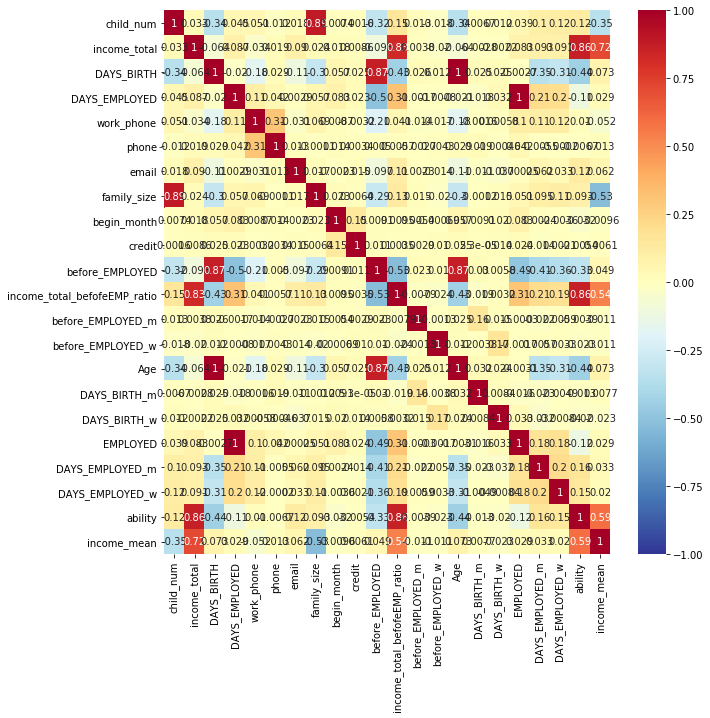

In [91]:
# 다중공선성 확인
plt.figure(figsize=(10,10))
sns.heatmap(train_corr,
              annot = True,
              cmap = 'RdYlBu_r',
              vmin = -1, vmax = 1
              )

In [92]:
# 파생변수와 다중공선 보이는 col 3개 삭제
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [95]:
train_corr2 = train.corr()

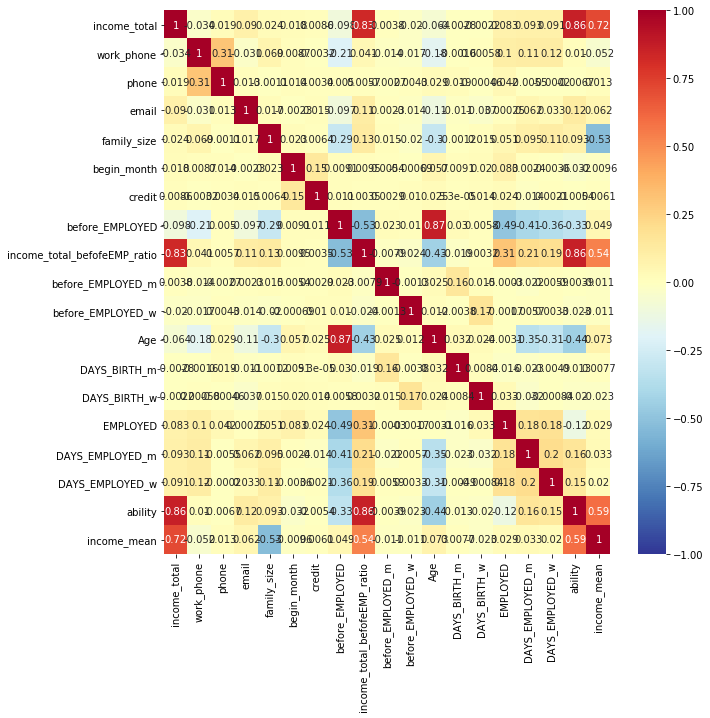

In [96]:
# 다중공선성 재확인
plt.figure(figsize=(10,10))
sns.heatmap(train_corr2,
              annot = True,
              cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
              vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [66]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,0,1,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,0,0,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


In [94]:
train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'before_EMPLOYED',
       'income_total_befofeEMP_ratio', 'before_EMPLOYED_m',
       'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED',
       'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean', 'ID'],
      dtype='object')

## Scaling, Encoding

### 1. Numeric, Category col분류

In [25]:
train.dtypes

gender                           object
car                              object
reality                          object
income_total                    float64
income_type                      object
edu_type                         object
family_type                      object
house_type                       object
work_phone                        int64
phone                             int64
email                             int64
occyp_type                       object
family_size                     float64
begin_month                     float64
credit                          float64
before_EMPLOYED                   int64
income_total_befofeEMP_ratio    float64
before_EMPLOYED_m               float64
before_EMPLOYED_w               float64
Age                               int64
DAYS_BIRTH_m                    float64
DAYS_BIRTH_w                    float64
EMPLOYED                          int64
DAYS_EMPLOYED_m                 float64
DAYS_EMPLOYED_w                 float64


In [26]:
num_feats = train.dtypes[train.dtypes != 'object'].index.tolist()
num_feats.remove('credit')
print('Number of num_feats : ', len(num_feats))

cat_feats = train.dtypes[train.dtypes == 'object'].index.tolist()
print('Number of cat_feats : ', len(cat_feats))

Number of num_feats :  18
Number of cat_feats :  9


In [27]:
num_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [28]:
cat_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

### 2. log scale

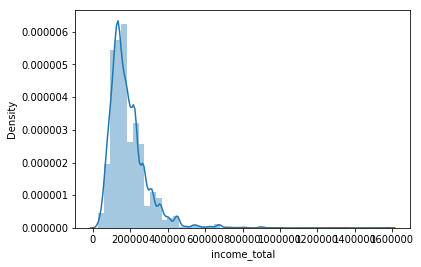

In [29]:
#total_income의 왜도 심함 확인
sns.distplot(train['income_total'])

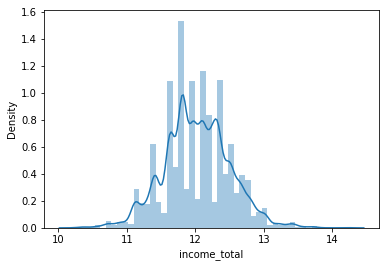

In [30]:
# 로그변환을 통환 정규분포화 확인
a = np.log1p(train['income_total'])
sns.distplot(a)

In [31]:
# income total
for df in [train, test]:
    df['income_total'] = np.log1p(df['income_total'])

### 3. OrdinalEncoder
* 카테고리 변수 ordinal_encoder 변환 -> ordinal encoder는 문자를 숫자로 변환
* ID는 변환 후 정수 처리

In [32]:
encoder = OrdinalEncoder(cat_feats)
train[cat_feats] = encoder.fit_transform(train[cat_feats], train['credit'])
test[cat_feats] = encoder.transform(test[cat_feats])

In [33]:
train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [34]:
train.dtypes

gender                            int32
car                               int32
reality                           int32
income_total                    float64
income_type                       int32
edu_type                          int32
family_type                       int32
house_type                        int32
work_phone                        int64
phone                             int64
email                             int64
occyp_type                        int32
family_size                     float64
begin_month                     float64
credit                          float64
before_EMPLOYED                   int64
income_total_befofeEMP_ratio    float64
before_EMPLOYED_m               float64
before_EMPLOYED_w               float64
Age                               int64
DAYS_BIRTH_m                    float64
DAYS_BIRTH_w                    float64
EMPLOYED                          int64
DAYS_EMPLOYED_m                 float64
DAYS_EMPLOYED_w                 float64


In [35]:
train.shape

(26451, 28)

In [36]:
test.shape

(10000, 27)

### 4. 클러스터링 구성
* EDA시 타겟을 결정짓는 뚜렷한 특징 갖는 feature가 없어서 clustering 시도

In [37]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

### 5. StandardScale
* income_total 제외한 나머지 numeric col 정규화

In [38]:
num_feats.remove('income_total')
scaler = StandardScaler()
train[num_feats] = scaler.fit_transform(train[num_feats])
test[num_feats] = scaler.transform(test[num_feats])

## Modeling - catboost
* fold 수 5~17까지 돌려보고 최적 fold 15로 판단 후 선택 -> 해보기
* parameter를 default로 두는 것이 logloss 가장 낮음

In [39]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [41]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
print('Accuracy Score: %.2f' % (accuracy_score(y_valid, cat_pred_test) * 100), '%')


----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346960	test: 1.0333820	best: 1.0333820 (0)	total: 24.7ms	remaining: 24.7s
100:	learn: 0.7053286	test: 0.6430792	best: 0.6430792 (100)	total: 7.01s	remaining: 1m 2s
200:	learn: 0.6869753	test: 0.6410587	best: 0.6410587 (200)	total: 14.4s	remaining: 57.4s
300:	learn: 0.6692872	test: 0.6411961	best: 0.6401680 (255)	total: 21.9s	remaining: 50.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6401680369
bestIteration = 255

Shrink model to first 256 iterations.
CV Log Loss Score: 0.640168

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346110	test: 1.0339653	best: 1.0339653 (0)	total: 21.5ms	remaining: 21.5s
100:	learn: 0.7034008	test: 0.6758889	best: 0.6758889 (100)	total: 6.56s	remaining: 58.4s
200:	learn: 0.6847406	test: 0.6752899	best: 0.6747008 (116)	total: 13.8s	remaining: 54.9s
Stopped by overfitting detector  (100 iterations wait)

bes